# Basket Clustering Analysis

This notebook performs basket clustering, compares K-Means with Agglomerative/DBSCAN/HDBSCAN, evaluates using silhouette/DBI/CH metrics, and analyzes actionability of clusters. It also compares basket-level vs product-level clustering for marketing insights.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load Transaction Data

In [2]:
# Load cleaned transaction data
df = pd.read_csv('../data/processed/cleaned_uk_data.csv')
print(f"Data shape: {df.shape}")
print(df.head())
print(f"Unique customers: {df['CustomerID'].nunique()}")
print(f"Unique products: {df['StockCode'].nunique()}")
print(f"Unique invoices: {df['InvoiceNo'].nunique()}")

Data shape: (485123, 11)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
0  2010-12-01 08:26:00       2.55     017850  United Kingdom       15.30   
1  2010-12-01 08:26:00       3.39     017850  United Kingdom       20.34   
2  2010-12-01 08:26:00       2.75     017850  United Kingdom       22.00   
3  2010-12-01 08:26:00       3.39     017850  United Kingdom       20.34   
4  2010-12-01 08:26:00       3.39     017850  United Kingdom       20.34   

   DayOfWeek  HourOfDay  
0          2          8  
1          2          8  
2      

## Preprocessing and Basket Matrix Creation

In [3]:
# Filter top products to reduce dimensionality
top_products = df['StockCode'].value_counts().head(100).index
df_filtered = df[df['StockCode'].isin(top_products)]

# Create basket matrix (binary: customer x product)
basket_matrix = df_filtered.pivot_table(
    index='CustomerID', 
    columns='StockCode', 
    values='Quantity', 
    aggfunc='sum', 
    fill_value=0
).astype(bool).astype(int)  # Binary matrix

print(f"Basket matrix shape: {basket_matrix.shape}")
print(basket_matrix.head())

Basket matrix shape: (3549, 100)
StockCode   20712  20719  20723  20724  20725  20726  20727  20728  20914  \
CustomerID                                                                  
000nan          1      1      1      1      1      1      1      1      1   
012747          0      0      0      0      0      0      0      0      0   
012748          1      1      1      1      1      1      1      1      1   
012749          0      0      0      0      0      0      0      0      1   
012820          1      0      0      0      0      0      0      0      0   

StockCode   21034  ...  84879  84946  84978  84991  85099B  85099C  85099F  \
CustomerID         ...                                                       
000nan          1  ...      1      1      1      1       1       1       1   
012747          0  ...      1      0      0      0       1       1       1   
012748          1  ...      1      1      1      1       1       1       1   
012749          0  ...      1      0 

## Clustering Algorithms

In [4]:
def run_clustering(X, algorithm, params):
    start_time = time.time()
    if algorithm == 'KMeans':
        model = KMeans(n_clusters=params['n_clusters'], random_state=RANDOM_STATE)
    elif algorithm == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage=params.get('linkage', 'ward'))
    elif algorithm == 'DBSCAN':
        model = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    
    labels = model.fit_predict(X)
    runtime = time.time() - start_time
    return labels, runtime

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(basket_matrix)

# Run algorithms
algorithms = [
    ('KMeans', {'n_clusters': 3}),
    ('Agglomerative', {'n_clusters': 3, 'linkage': 'ward'}),
    ('DBSCAN', {'eps': 1.5, 'min_samples': 5})
]

results = {}
for algo, params in algorithms:
    labels, runtime = run_clustering(X_scaled, algo, params)
    results[algo] = {'labels': labels, 'runtime': runtime}
    print(f"{algo}: {len(set(labels))} clusters, runtime: {runtime:.2f}s")

KMeans: 3 clusters, runtime: 2.00s


Agglomerative: 3 clusters, runtime: 0.99s
DBSCAN: 32 clusters, runtime: 0.07s


## Evaluation Metrics

In [5]:
def evaluate_clustering(X, labels):
    if len(set(labels)) <= 1:
        return {'Silhouette': np.nan, 'DBI': np.nan, 'CH': np.nan}
    
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    return {'Silhouette': sil, 'DBI': dbi, 'CH': ch}

# Evaluate each algorithm
evaluation_results = {}
for algo, res in results.items():
    metrics = evaluate_clustering(X_scaled, res['labels'])
    evaluation_results[algo] = {**metrics, 'Runtime': res['runtime']}

eval_df = pd.DataFrame(evaluation_results).T
print(eval_df)

               Silhouette       DBI          CH   Runtime
KMeans           0.241521  3.454854  271.353596  2.000932
Agglomerative    0.158930  3.683077  215.611614  0.991364
DBSCAN          -0.267137  2.073760    1.897755  0.068417


## Actionability Analysis

In [6]:
def analyze_actionability(basket_matrix, labels, algo_name):
    basket_with_labels = basket_matrix.copy()
    basket_with_labels['cluster'] = labels
    
    # Cluster sizes
    cluster_sizes = basket_with_labels['cluster'].value_counts().sort_index()
    
    # Top products per cluster
    top_products = {}
    for cluster in cluster_sizes.index:
        cluster_data = basket_with_labels[basket_with_labels['cluster'] == cluster]
        product_sums = cluster_data.drop('cluster', axis=1).sum().sort_values(ascending=False)
        top_products[cluster] = product_sums.head(5).index.tolist()
    
    return {
        'cluster_sizes': cluster_sizes,
        'top_products': top_products
    }

# Analyze actionability for each algorithm
actionability = {}
for algo, res in results.items():
    actionability[algo] = analyze_actionability(basket_matrix, res['labels'], algo)

# Print results
for algo, analysis in actionability.items():
    print(f"\n{algo} Actionability:")
    print(f"Cluster sizes: {analysis['cluster_sizes'].to_dict()}")
    for cluster, products in analysis['top_products'].items():
        print(f"Cluster {cluster} top products: {products}")


KMeans Actionability:
Cluster sizes: {0: 230, 1: 2586, 2: 733}
Cluster 0 top products: ['85099B', '20725', '20727', '23203', '20728']
Cluster 1 top products: ['85123A', '22423', '84879', '47566', '21034']
Cluster 2 top products: ['22423', '85123A', '22720', '22086', '22960']

Agglomerative Actionability:
Cluster sizes: {0: 350, 1: 497, 2: 2702}
Cluster 0 top products: ['85099B', '23203', '20725', '20727', '20728']
Cluster 1 top products: ['22423', '22697', '22699', '22698', '85123A']
Cluster 2 top products: ['85123A', '84879', '47566', '22423', '22457']

DBSCAN Actionability:
Cluster sizes: {-1: 3256, 0: 20, 1: 12, 2: 12, 3: 6, 4: 17, 5: 12, 6: 6, 7: 5, 8: 15, 9: 8, 10: 24, 11: 13, 12: 6, 13: 18, 14: 7, 15: 5, 16: 8, 17: 5, 18: 7, 19: 5, 20: 13, 21: 17, 22: 5, 23: 8, 24: 5, 25: 6, 26: 5, 27: 5, 28: 6, 29: 6, 30: 6}
Cluster -1 top products: ['85123A', '22423', '47566', '84879', '22086']
Cluster 0 top products: ['21790', '20712', '22961', '23208', '23207']
Cluster 1 top products: ['2245

## Comparison and Visualization

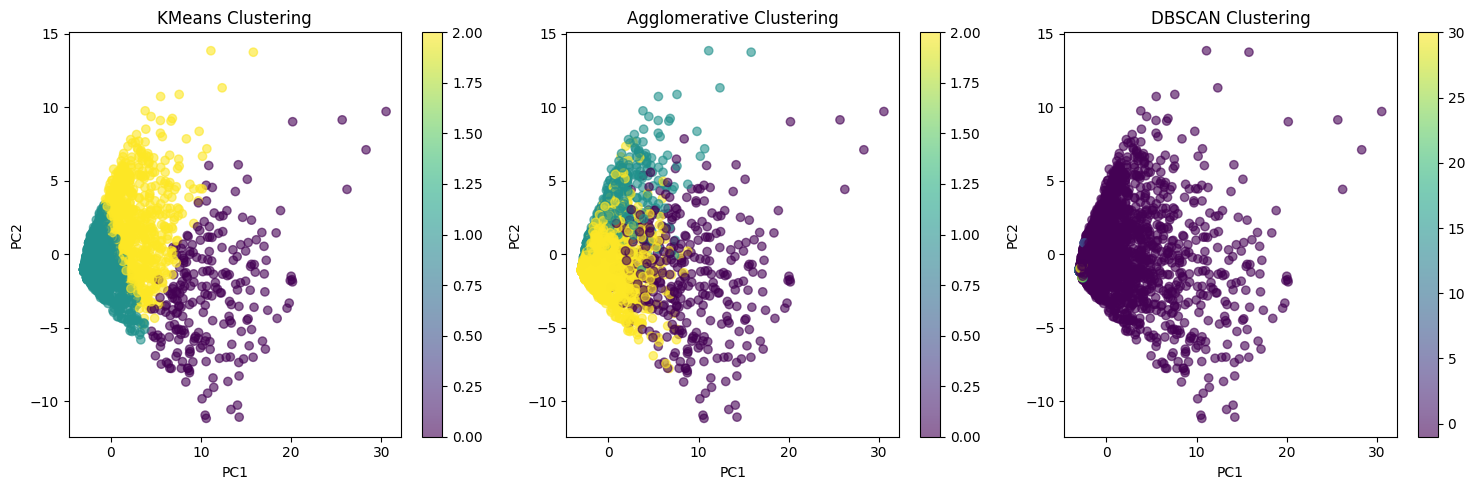


Summary Comparison:
               Silhouette       DBI          CH   Runtime Actionability
KMeans           0.241521  3.454854  271.353596  2.000932    3 clusters
Agglomerative    0.158930  3.683077  215.611614  0.991364    3 clusters
DBSCAN          -0.267137  2.073760    1.897755  0.068417   32 clusters


In [7]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (algo, res) in enumerate(results.items()):
    ax = axes[i]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=res['labels'], cmap='viridis', alpha=0.6)
    ax.set_title(f'{algo} Clustering')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

# Summary table
summary = eval_df.copy()
summary['Actionability'] = [f"{len(actionability[algo]['cluster_sizes'])} clusters" for algo in summary.index]
print("\nSummary Comparison:")
print(summary)